## Set up data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
import stan

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
from utils import *

In [5]:
bpath = '~/source/rethinking/'

In [6]:
df = pd.read_csv(bpath + 'data/foxes.csv', sep=';')

In [7]:
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [8]:
scaler = StandardScaler()

In [9]:
X_unscaled = df[['avgfood','groupsize','area','weight']]

In [10]:
scaler.fit(X_unscaled)

StandardScaler()

In [11]:
X_scaled = scaler.transform(X_unscaled)

In [12]:
df_scaled = pd.DataFrame(X_scaled, columns=['avgfood','groupsize','area','weight'])

In [13]:
df_scaled[['group']] = df[['group']]

In [14]:
df_scaled.head()

,avgfood,groupsize,area,weight,group
0,-1.933180,-1.530701,-2.249313,0.415931,1
1,-1.933180,-1.530701,-2.249313,-1.433238,1
2,-1.122886,-1.530701,-1.210738,0.678887,2
3,-1.122886,-1.530701,-1.210738,1.306586,2
4,-1.325459,-1.530701,-1.135008,1.119973,3


## Prior predictive checks

In [15]:
num_priors = 50

In [16]:
priors_df = pd.DataFrame({'alpha': np.random.normal(0, 0.5, num_priors),
                         'beta': np.random.normal(0, 0.5, num_priors),
                         'sigma': np.random.exponential(1, num_priors)})

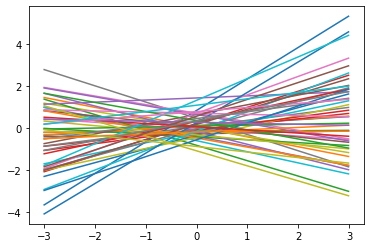

In [17]:
x_vals = np.arange(-3, 3, 0.01)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

for rowno in range(0, num_priors):
    y_vals = priors_df['alpha'][rowno] + priors_df['beta'][rowno]*x_vals
    sns.lineplot(x=x_vals, y=y_vals)

## Exercise 1

In [18]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(0, 0.2);
  beta ~ normal(0, 0.5);
  sigma ~ exponential(1);
}
"""

In [19]:
model_data = {
    "N": len(df_scaled),
    "x": df_scaled['area'].to_numpy(),
    "y": df_scaled['weight'].to_numpy()
}

In [20]:
posterior = stan.build(model_code, data=model_data, random_seed=456)

Building...

Building: found in cache, done.

In [21]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000103 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_do0_w0w_/model_ftobwla7.stan', line 13, column 2 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely

In [22]:
model_summary(fit)

,param,mean,std,5.0%,95.0%
0,alpha,0.002021,0.085627,-0.135698,0.140440
0,beta,0.019148,0.089494,-0.129892,0.170746
0,sigma,1.013390,0.067775,0.908328,1.128628


## Exercise 2

In [23]:
model_data = {
    "N": len(df_scaled),
    "x": df_scaled['avgfood'].to_numpy(),
    "y": df_scaled['weight'].to_numpy()
}

In [24]:
posterior = stan.build(model_code, data=model_data, random_seed=456)

Building...

Building: found in cache, done.

In [25]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_do0_w0w_/model_ftobwla7.stan', line 13, column 2 to column 38)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely 

In [26]:
model_summary(fit)

,param,mean,std,5.0%,95.0%
0,alpha,-0.000177,0.086213,-0.143704,0.136832
0,beta,-0.024290,0.092852,-0.175684,0.126992
0,sigma,1.015478,0.067549,0.911224,1.131000


## Exercise 3

In [27]:
model_code = """
data {
  int<lower=0> N;
  vector[N] F;
  vector[N] G;
  vector[N] y;
}
parameters {
  real a;
  real bF;
  real bG;
  real<lower=0> sigma;
}
model {
  y ~ normal(a + bF*F + bG*G, sigma);
  a ~ normal(0, 0.2);
  bF ~ normal(0, 0.5);
  bG ~ normal(0, 0.5);
  sigma ~ exponential(1);
}
"""

In [28]:
model_data = {
    "N": len(df_scaled),
    "F": df_scaled['avgfood'].to_numpy(),
    "G": df_scaled['groupsize'].to_numpy(),
    "y": df_scaled['weight'].to_numpy()
}

In [29]:
posterior = stan.build(model_code, data=model_data, random_seed=456)

Building...

Building: found in cache, done.

In [30]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   8% (600/8000)
Sampling:  32% (2600/8000)
Sampling:  58% (4600/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000144 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000151 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.51 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_71lm2gzt/model_rhecbsva.stan', line 15, column 2 to 

In [31]:
model_summary(fit)

,param,mean,std,5.0%,95.0%
0,a,-0.000389,0.080900,-0.132808,0.132413
0,bF,0.472861,0.182890,0.172418,0.769724
0,bG,-0.568797,0.181896,-0.868554,-0.276158
0,sigma,0.968222,0.065490,0.867115,1.080713


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


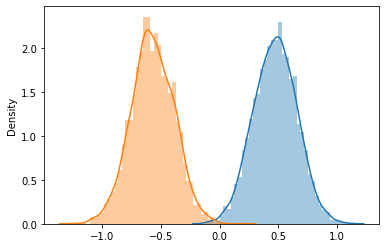

In [32]:
fig, ax = plt.subplots()

for param in ['bF','bG']:
    sns.distplot(fit[param], ax=ax)